# Section 3 - Methodology

## Section 3.2 - Gaussian Process regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as k
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

In [2]:
df_ds = pd.read_excel("../Data/Dataset_Sample_GDP_Weekly.xlsx")
df_df = pd.read_excel("../Data/dataset_X_Final_Weekly.xlsx")

In [3]:
xs = np.array(df_ds["ID_S"])
ys_ = np.array(df_ds["GDP_eu"])
x_final_ = np.array(df_df["ID_S"])
ys = (ys_-ys_.mean())/ys_.std()
xs = xs/xs.max()
x_final = x_final_/x_final_.max()

In [4]:
kernel = k.Matern(length_scale=1.0, length_scale_bounds=(1.0, 100.0), nu=1)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(np.atleast_2d(xs).T, ys)
y_mean, y_std = gp.predict(x_final[:, None], return_std=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [5]:
df_ds_2 = pd.read_excel("../Data/Dataset_eua_IMv4.3.xlsx")
df_df_2 = pd.read_excel("../Data/Dataset_X_Final_Weekly.xlsx")

In [6]:
x_final__2 = np.array(df_df_2["ID_S"])
xs__2 = np.array(df_ds_2["DateS"])
df_ds_2 = (df_ds_2 - df_ds_2.mean())/df_ds_2.std()
xs_2 = xs__2/xs__2.max()
x_final_2 = x_final__2/x_final__2.max()

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def predict_gp(x, y, x_final, error, nu):
    kernel =k.Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1)
    gp = GaussianProcessRegressor(kernel, alpha=error)
    gp.fit(np.atleast_2d(x).T, y)
    y_pred = gp.predict(np.atleast_2d(x_final).T, return_std=False)
    return y_pred

def compute_aggregation(y, N):
    rm_ys = running_mean(y, N)
    ys_test_agg = y[int((N-1)/2):int(-(N-1)/2)] - rm_ys
    x_final_agg = x_final[int((N-1)/2):int(-(N-1)/2)]
    err = 2*np.std(ys_test_agg)
    return err, x_final_agg, ys_test_agg

/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_22110/1424237.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_ds_2 = (df_ds_2 - df_ds_2.mean())/df_ds_2.std()


In [7]:
N = 5
ys_2 = np.array(df_ds_2['eua_last'])
err_2, _, _ = compute_aggregation(ys_2, N)
y_pred_2 = predict_gp(xs_2, ys_2, x_final_2, error=err_2, nu = 1)

/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_22110/4129630441.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(x_final, y_mean, 'k', lw=3, zorder=10, color = 'k', label="Imputed GDP")
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_22110/4129630441.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_final_2, y_pred_2, 'k', zorder=20, color = 'k', label="Aggregated EU ETS")


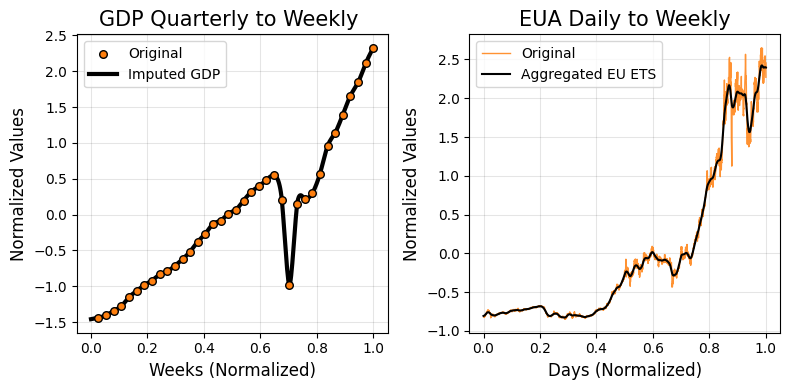

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.scatter(xs, ys, s=30, label="Original", zorder=20, edgecolor='k', color ='tab:orange')
ax1.plot(x_final, y_mean, 'k', lw=3, zorder=10, color = 'k', label="Imputed GDP")
ax2.plot(xs_2, df_ds_2['eua_last'], label="Original", zorder=10, lw=1, color ='tab:orange', alpha = 0.85)
ax2.plot(x_final_2, y_pred_2, 'k', zorder=20, color = 'k', label="Aggregated EU ETS")
ax1.legend()
ax2.legend()
ax1.set_title('GDP Quarterly to Weekly ', fontsize=15)
ax2.set_title('EUA Daily to Weekly', fontsize=15)
ax1.grid(axis='both',color="black", alpha=.1)
ax2.grid(axis='both',color="black", alpha=.1)
ax1.set_xlabel('Weeks (Normalized)', fontsize=12)
ax2.set_xlabel('Days (Normalized)', fontsize=12)
ax1.set_ylabel('Normalized Values', fontsize=12)
ax2.set_ylabel('Normalized Values', fontsize=12)
plt.tight_layout()
#plt.savefig('../Figures/Fig3_AggregationImputation.png', dpi=700, bbox_inches='tight')

Figure 3: Imputation and aggregation using GPs. In the left panel, a GP
is used to impute the GDP time series variable from quarterly to weekly fre-
quency. In the right panel, a GP is used to aggregate the target time series of
EUA prices from daily to weekly frequency.

***